# Comparison between interests generation methods in:
### score in link prediction and macro homophily metrics

In [1]:
from n2i.__main__ import n2i_main, n2i_nx_graph
from n2i.node2vec import read_graph
import tensorflow as tf
import networkx as nx
from scipy.spatial import distance
import itertools as IT

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### Import and display the graph

In [3]:
graph_path = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'

G = read_graph(weighted=False, 
                   graph=graph_path,
                   directed=False)

In [4]:
'''
graph = nx.watts_strogatz_graph(200, 10, 0.1, seed=42)
for edge in graph.edges():
            graph[edge[0]][edge[1]]['weight'] = 1
'''

"\ngraph = nx.watts_strogatz_graph(200, 10, 0.1, seed=42)\nfor edge in graph.edges():\n            graph[edge[0]][edge[1]]['weight'] = 1\n"

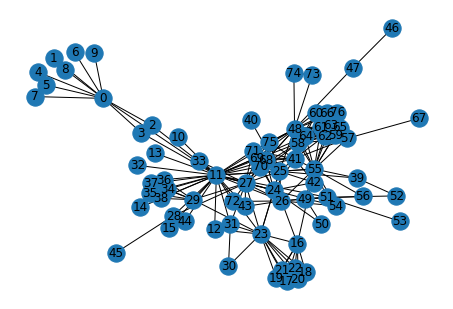

In [5]:
nx.draw(G, with_labels = True)
plt.show()

### learning interests via tensorflow implementation

In [6]:
tf.reset_default_graph()
tf_emb = n2i_nx_graph(nx_graph=G, topics=2, use_tf=True, seed=10, translate=False, reduce=False, 
                   window_size=10,
                   walk_length=100,
                   num_walks=30,
                   dimensions=2,
                   p=0.1,
                   q=10,
                   beta=0.03,
                   prior='beta'
                   )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
nodes = [_ for _ in range(len(tf_emb))]
x_plot = [tf_emb[_, 0] for _ in range(len(tf_emb))]
y_plot = [tf_emb[_, 1] for _ in range(len(tf_emb))]

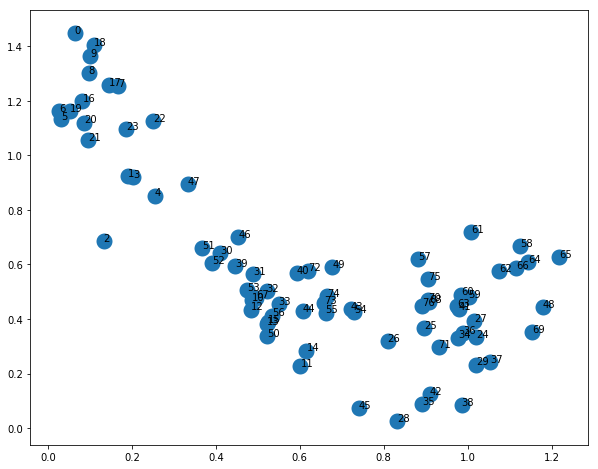

In [8]:
fig, ax = plt.subplots()
ax.scatter(x_plot, y_plot, linewidths=10)
for _ in range(len(nodes)):
    ax.annotate(nodes[_], (x_plot[_], y_plot[_]))
fig.set_size_inches(10, 8)

### defining function for evaluating the score in link prediction

In [9]:
def evaluate_score(graph, emb):
    '''
    Evaluetes the score in link prediction
    '''
    # creating X and y concatenating embeddings of the two linked nodes (y=1)
    X = []
    y = []
    for u, v in graph.edges():
        arr_u = list(emb[u])
        arr_v = list(emb[v])
        X.append(arr_u + arr_v)
        y.append(1)
        
    # adding no-linked nodes to X and y (y=0)
    missing = [pair for pair in IT.combinations(graph.nodes(), 2) if not graph.has_edge(*pair)]
    import random
    random.seed(42)
    no_edges = random.choices(missing, k=len(graph.edges()))
    for u, v in no_edges:
        arr_u = list(emb[u])
        arr_v = list(emb[v])
        X.append(arr_u + arr_v)
        y.append(0)
        
    # testing
    from sklearn.utils import shuffle
    X, y = shuffle(X, y, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state=42)
    # Create one-vs-rest logistic regression object
    clf = LogisticRegression(random_state=0, multi_class='ovr')
    # Train model
    model = clf.fit(X_train, y_train)
    
    return model.score(X_test, y_test)

In [10]:
evaluate_score(G, tf_emb)

0.558282208588957

### defining the random uniform generation of interests

In [11]:
def random_emb(nr_nodes, nr_dim):
    r_emb = [0 for _ in range(nr_nodes)]
    for n in range(nr_nodes):
        r_emb[n] = np.random.rand(nr_dim)
    return np.array(r_emb)

In [12]:
nr_nodes, nr_dim = tf_emb.shape
r_emb = random_emb(nr_nodes, nr_dim)

In [13]:
evaluate_score(G, r_emb)

0.6012269938650306

### defining metrics for homophily evaluation

In [14]:
EPSILON = 1E-5
METRIC_NAMES = ['ratio', 'sub', 'like']
def homophily_metrics(similarity_edges, similarity_nonedges):
    return {
        'ratio': np.mean(similarity_edges) / np.mean(similarity_nonedges),
        'sub': np.mean(similarity_edges) - np.mean(similarity_nonedges),
        'like': np.sum(np.log(similarity_edges + EPSILON)) + np.sum(np.log(1 - similarity_nonedges + EPSILON)) ,
    }

In [15]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            #print(G.nodes[i]['interests'], emb[i])
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 5000)

### Propagation method for generating interests

In [16]:
def propag_emb(G, nr_nodes, nr_topics):
    '''
    generates interests with the propagation method starting from "n" nodes
    '''
    # INITIALIZE
    np.random.seed(420)
    for i in list(G.nodes):
        interests = np.random.dirichlet(np.ones(nr_topics)*1./nr_topics)
        G.nodes[i]['interests'] = interests
    
    # SELECT INFLUENCERS
    # start with a random node
    influencers = [np.random.choice(G.nodes)]

    for i in range(14):
        # calculate distances to current influencers
        sp = {i: nx.shortest_path(G, i) for i in influencers}
        distances = np.array([list(len(sp[j][i]) for j in influencers) for i in G.nodes()])
        # select the node fartest from all influencers
        influencers.append(distances.min(axis=1).argmax()) 
      
    # PROPAGATION STEP
    for c in range(10000):
        i = np.random.choice(nr_nodes)
        interests_i = G.nodes[i]['interests']
        lr = 0.5 if i in influencers else 0.01
        #lr = 0.1
        for j in list(G.neighbors(i)):
            if j in influencers:
                continue
            interests_j = G.nodes[j]['interests']
            interests_j += interests_i * lr
            interests_j /= interests_j.sum()
            G.nodes[j]['interests'] = interests_j

        if c%1000 == 0:
            si = sim_in(G)
            so = sim_out(G, 5000)
            #print (si, so, si/so)

    # preparing matrix
    prop_emb = [G.nodes[_]['interests'] for _ in range(nr_nodes)]
    return np.array(prop_emb)

In [17]:
nr_nodes, nr_topics = tf_emb.shape
p_emb = propag_emb(G, nr_nodes, nr_topics)

In [18]:
evaluate_score(G, p_emb)

0.6073619631901841

### Function for evaluating homophily metrics

In [19]:
def evaluate_metrics(graph, emb):
    '''
    Returns the three metrics for si and so defined in homophily_metrics function
    '''
    # building the graph
    for i in graph.nodes:
        graph.nodes[i]['interests'] = emb[i]
        
    # calculating si and so
    output = {}
    si = sim_in(graph)
    so = sim_out(graph, 5000)
    output['si'] = round(si, 4)
    output['so'] = round(so, 4)
    for name, metric in homophily_metrics(si, so).items():
        output[name] = round(metric, 4)

    return output

## Comparing all three methods

In [20]:
w_graph = nx.watts_strogatz_graph(200, 10, 0.1, seed=42)
for edge in w_graph.edges():
    w_graph[edge[0]][edge[1]]['weight'] = 1

In [21]:
def compare_methods(graph, beta, p=0.1, q=10, nr_topics=2):
    '''
    Comprare interests method creation
    '''
    nr_nodes = graph.number_of_nodes()
    
    tf.reset_default_graph()
    tf_emb = n2i_nx_graph(nx_graph=graph, topics=nr_topics, use_tf=True, seed=10, translate=False, reduce=False, 
                   window_size=10,
                   walk_length=100,
                   num_walks=30,
                   dimensions=nr_topics,
                   p=p,
                   q=q,
                   beta=beta,
                   prior='beta'
                   )
    tf_score = evaluate_score(graph, tf_emb)
    tf_metrics = evaluate_metrics(graph, tf_emb)
    p_emb = propag_emb(graph, nr_nodes, nr_topics)
    p_score = evaluate_score(graph, p_emb)
    p_metrics = evaluate_metrics(graph, p_emb)
    r_emb = random_emb(nr_nodes, nr_topics)
    r_score = evaluate_score(graph, r_emb)
    r_metrics = evaluate_metrics(graph, r_emb)
    
    
    print('Tf score: ', tf_score, ' Propag score: ', p_score, ' Random score: ', r_score)
    print('Tensfl metrics: ', tf_metrics, '\nPropag metrics: ', p_metrics, '\nRandom metrics: ', r_metrics)


    

In [23]:
for p, q in [(0.1, 1), (1, 1), (0.1, 10), (0.1, 100)]:
    for beta in [10, 1, 0.1, 0.01]:
        print('\nSETTING:= p: ',p ,' q: ', q, ' beta: ', beta)
        compare_methods(w_graph, beta, p=p, q=q)


SETTING:= p:  0.1  q:  1  beta:  10

Tf score:  0.6359375  Propag score:  0.6046875  Random score:  0.5203125
Tensfl metrics:  {'si': 0.9706, 'so': 0.862, 'ratio': 1.126, 'sub': 0.1086, 'like': -2.01} 
Propag metrics:  {'si': 0.953, 'so': 0.7575, 'ratio': 1.2581, 'sub': 0.1955, 'like': -1.4647} 
Random metrics:  {'si': 0.842, 'so': 0.8367, 'ratio': 1.0063, 'sub': 0.0053, 'like': -1.9842}

SETTING:= p:  0.1  q:  1  beta:  1

Tf score:  0.64375  Propag score:  0.6046875  Random score:  0.5203125
Tensfl metrics:  {'si': 0.9656, 'so': 0.8429, 'ratio': 1.1455, 'sub': 0.1226, 'like': -1.8861} 
Propag metrics:  {'si': 0.953, 'so': 0.7575, 'ratio': 1.2581, 'sub': 0.1955, 'like': -1.4647} 
Random metrics:  {'si': 0.842, 'so': 0.8367, 'ratio': 1.0063, 'sub': 0.0053, 'like': -1.9842}

SETTING:= p:  0.1  q:  1  beta:  0.1

Tf score:  0.6703125  Propag score:  0.6046875  Random score:  0.5203125
Tensfl metrics:  {'si': 0.9646, 'so': 0.8412, 'ratio': 1.1467, 'sub': 0.1234, 'like': -1.8759} 
Propag 

In [26]:
compare_methods(w_graph, beta=0.001, p=0.001, q=1000)


Tf score:  0.621875  Propag score:  0.6046875  Random score:  0.5203125
Tensfl metrics:  {'si': 0.9322, 'so': 0.7597, 'ratio': 1.227, 'sub': 0.1725, 'like': -1.4961} 
Propag metrics:  {'si': 0.953, 'so': 0.7575, 'ratio': 1.2581, 'sub': 0.1955, 'like': -1.4647} 
Random metrics:  {'si': 0.842, 'so': 0.8367, 'ratio': 1.0063, 'sub': 0.0053, 'like': -1.9842}
